In [1]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.8.0'

In [2]:
from google.colab import drive

In [3]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [4]:
! pip install kaggle

In [5]:
! mkdir ~/.kaggle

In [6]:
! cp /content/gdrive/MyDrive/Learning/kaggle.json ~/.kaggle/kaggle.json

In [7]:
! kaggle competitions download -c rsna-pneumonia-detection-challenge

100% 3.65G/3.66G [01:19<00:00, 64.5MB/s]
100% 3.66G/3.66G [01:19<00:00, 49.3MB/s]


In [8]:
! ls /content

gdrive	rsna-pneumonia-detection-challenge.zip	sample_data


In [9]:
! mkdir -p /content/rsna-pneumonia-detection-challenge

In [10]:
! unzip -q /content/rsna-pneumonia-detection-challenge.zip -d /content/rsna-pneumonia-detection-challenge

In [11]:
! ls /content

gdrive				    rsna-pneumonia-detection-challenge.zip
rsna-pneumonia-detection-challenge  sample_data


In [12]:
! pip install pydicom

     |████████████████████████████████| 2.0 MB 4.2 MB/s 


In [13]:
# Adding imports required for data cleansing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline 

# Adding imports for misc and data prep
import os
import cv2
import pydicom #For displaying dcm images

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Initialize the random number generator
import random

np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [15]:
input_path = "/content/rsna-pneumonia-detection-challenge/"

train_img_path = input_path + 'stage_2_train_images/'
test_img_path = input_path + 'stage_2_test_images/'

# Contains information on the bounding box for each patient id
bounding_box = input_path + 'stage_2_train_labels.csv' 

# Contains detailed class saying whether data refers to Normal, Pneumonia or any other ailments
detailed_class_info = input_path + 'stage_2_detailed_class_info.csv'

# Contains the target data for which we need to train the images
sample_submission = input_path + 'stage_2_sample_submission.csv'

In [16]:
bounding_box_df = pd.read_csv(bounding_box)
detailed_class_info_df = pd.read_csv(detailed_class_info)
sample_submission_df = pd.read_csv(sample_submission)

For each of the dataframe that is loaded, we are going to perform following,


1. Check the shape of dataframe
2. Sample content of dataframe
3. Dataframe info check
4. Duplicate check
5. Write consolidated observations on each dataframe

Step 1.1 - Working with bounding_box dataframes

Shape of dataframe:

In [17]:
print ("Shape of bounding_box dataframe is", bounding_box_df.shape)

Shape of bounding_box dataframe is (30227, 6)


Sample Content:

In [18]:
bounding_box_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Dataframe info:

In [19]:
bounding_box_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


Data looks to be clean. 

*   No null values in any columns.
*   'patientId' columns is our key column in this data frame.

Duplicate check:

In [20]:
# Check for any duplicates in our key column
bounding_box_df['patientId'].is_unique

False

In [21]:
# Lets check out how many duplicates we have !
bounding_box_df_duplicate = bounding_box_df[bounding_box_df.duplicated(['patientId'])]
bounding_box_df_duplicate.shape

(3543, 6)

So we have around 3543 duplicate records of patientId's out of 30227 samples in the dataframe.

Following inferences can be made...

*   So, do we have "30227-3543=26684" training images ? (one training image should be for one patient)
*   That means, we should have multiple bounding boxes for one patient id, which makes sense for duplicate rows in bounding_box_df dataframe.

In [22]:
path, dirs, files = next(os.walk(train_img_path))
train_img_count = len(files)
train_img_count

26684

* Okay. So, we have 26684 unique patients and a total of 30227 bounding box data.
* That confirms our assumption that there are multiple bounding boxes for some of the patient dcm images.


Consolidated observations on train labels dataframe:

* There are 30227 rows in this dataframe, which are infact bounding boxes data for various patientId's.
* We have 26684 dcm images for 30227 bounding box data. So, there are multiple bounding boxes in some patientId dcm files.
* Train label dataframe holds data which can be interpreted as,
patiendId column, having unique id assigned to each patient.
  * if Target is '1', i.e., if its a Pneumonia patient,
we have bounding box co-ordinates with x, y, width and height
  * if Target is '0', i.e., if its NOT a pneumonia patient,
we don't have bounding box co-ordinates


Step 1.2 - Working with detailed class info dataframes

Shape of dataframe

In [23]:
print ("Shape of detailed class info dataframe is", detailed_class_info_df.shape)

Shape of detailed class info dataframe is (30227, 2)


Sample Content:

In [24]:
detailed_class_info_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


Dataframe info:

In [25]:
detailed_class_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


* Data looks to be clean. No null values in any columns.
* 'patientId' columns is our key column in this data frame. Based on patientId, data in this dataframe relates to data in bounding_box_df (bounding box) dataframe.

Duplicate check:

In [26]:
# Check for any duplicates in our key column
detailed_class_info_df['patientId'].is_unique

False

In [27]:
# Lets check out how many duplicates we have !
detailed_class_info_df_duplicate = detailed_class_info_df[detailed_class_info_df.duplicated(['patientId'])]
detailed_class_info_df_duplicate.shape

(3543, 2)

Good to see that duplicate record count for patientId is 3543 and this exactly matches the duplicate count in bounding_box_df (bounding box) dataframe.

**Consolidated observations on detailed class info dataframes:**

* There are 30227 rows in this dataframe.
* There are 3543 duplicate records in this dataframe. This count exactly matches duplicate count in bounding_box_df (bounding box) dataframe.
* Above datafarme holds additional detailed information about the positive and negative classes (Target column) in the training set
* This data may be used to build more nuanced models, as including this information with training data will improve the FPR rate of our model and thereby our model will be more robust !
* So, let us merge bounding_box_df and detailed_class_info_df dataframes to have one single dataframe of interest.

(Merge) Working with bounding-box and detailed-class-info dataframes

In [28]:
train_data_df = pd.concat([bounding_box_df, detailed_class_info_df['class']], axis = 1)
train_data_df.shape

(30227, 7)

Sample Content:

In [29]:
train_data_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


Now we have one single dataframe having details about bounding-box and detailed-class-info dataframes

Step 1.3 - Working with sample submission dataframes (target information dataframe)

Shape of dataframe

In [30]:
print ("Shape of sample_submission_df is", sample_submission_df.shape)

Shape of sample_submission_df is (3000, 2)


Sample Content:

In [31]:
sample_submission_df.head()

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.5 0 0 100 100
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.5 0 0 100 100
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.5 0 0 100 100
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.5 0 0 100 100
4,00100a24-854d-423d-a092-edcf6179e061,0.5 0 0 100 100


Dataframe info:

In [32]:
sample_submission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   patientId         3000 non-null   object
 1   PredictionString  3000 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


* Target sample data as well looks clean. No null values in any columns.
* 'patientId' columns is our key column and this should relate to the test images that we have in the dataset.

Duplicate check:

In [33]:
# Check for any duplicates in our key column
sample_submission_df['patientId'].is_unique

True

* We have not got any duplicates in sample-submission dataframe.
* This tells that we should as well have 3000 sample images in our test image directory.

In [34]:
path, dirs, files = next(os.walk(test_img_path))
test_img_count = len(files)
test_img_count

3000

* Okay. So, our test data set is clean.
* we have 3000 samples in the dataframe and 3000 images in the test image directory, which indicates that we have test images for all records in the test/target dataframe.

Consolidated observations on test labels dataframe:

* Target data is clean
  * There are 3000 records in sample-submission dataframe.
  * 3000 record count in dataframe is exactly matching the number of test images in the dataset.
  * There are no duplicate records in the dataframe.
* sample-submission dataframe contains columns 'PredictionString' that holds * the target (expected) bounding boxes for the test input dcm image.
* Sample content of 'PredictionString' columns is as:
  * 0.5 0 0 100 100
  * In the above data each value indicates following:
    * confidence-of-prediction bounding-box-x-coordinate bounding-box-y-coordinate width-of-bounding-box height-of-bounding-box
  * In above example:
    * confidence-of-prediction is 0.5
    * bounding-box-x-coordinate is 0
    * bounding-box-y-coordinate is 0
    * width-of-bounding-box is 100
    * height-of-bounding-box is 100

Note: One test image contains only one bounding boxes as reference. Prediction can have multiple bounding boxes detected.

**Step 2 - Data Visualization**

Step 2.1 How balanced is our target data ?

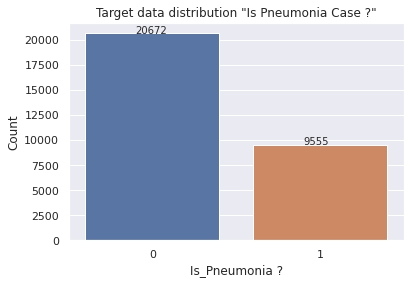

In [35]:
ax = sns.countplot(x="Target", data = bounding_box_df, label="Count");
plt.title('Target data distribution \"Is Pneumonia Case ?\"')
plt.xlabel('Is_Pneumonia ?')
plt.ylabel('Count')
for p in ax.patches:
        ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()))

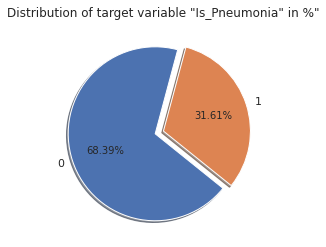

In [36]:
myexplode = [0.1, 0]
plt.pie(bounding_box_df['Target'].value_counts(), 
        labels=bounding_box_df['Target'].unique(), 
        explode=myexplode,
        startangle=75, 
        shadow = True, 
        autopct='%2.2f%%');
plt.title('Distribution of target variable \"Is_Pneumonia\" in %"');


**Step 2.2 Class distribution in detailed_class_info dataframe**

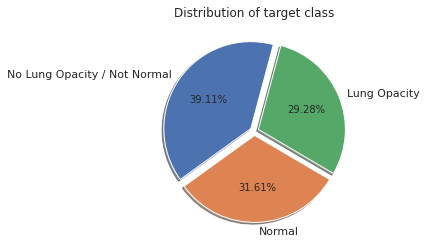

In [37]:
myexplode = [0.05, 0.05, 0.05]
plt.pie(detailed_class_info_df['class'].value_counts(), 
        labels=detailed_class_info_df['class'].unique(), 
        explode=myexplode,
        startangle=75, 
        shadow = True, 
        autopct='%2.2f%%');
plt.title('Distribution of target class');

Note: Normal class % (31.61) in detailed_class_info dataframe, matches with Normal class % (Target 0) in bounding_box dataframe

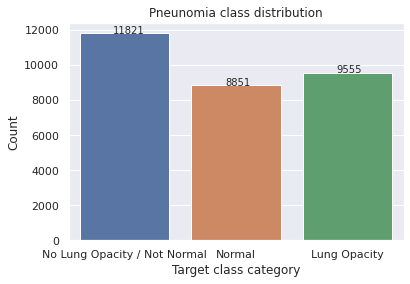

In [38]:
ax = sns.countplot(x='class', data = detailed_class_info_df, label="Count");
plt.title('Pneunomia class distribution')
plt.xlabel('Target class category')
plt.ylabel('Count')
for p in ax.patches:
        ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()))

We have good distrubution of all three classes in our dataset. Target class is balanced to good extent.

**Step 2.3 Read and visualize sample dicom images**

-- Let us seggregate positive and negative cases from dataframe --

In [39]:
# Get the dataframe having only POSITIVE cases
pos_df = train_data_df[(train_data_df['Target'] == 1)][['patientId', 'x', 'y', 'width', 'height', 'class']]
pos_df.head()

,patientId,x,y,width,height,class
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,Lung Opacity
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,Lung Opacity
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,Lung Opacity


In [40]:
# Get the dataframe having only NEGATIVE cases -> Target class - 'NORMAL'
neg_normal_df = train_data_df[(train_data_df['Target'] == 0) & (train_data_df['class'] == 'Normal')][['patientId', 'x', 'y', 'width', 'height', 'class']]
neg_normal_df.head()

,patientId,x,y,width,height,class
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,Normal
11,009482dc-3db5-48d4-8580-5c89c4f01334,NaN,NaN,NaN,NaN,Normal
12,009eb222-eabc-4150-8121-d5a6d06b8ebf,NaN,NaN,NaN,NaN,Normal
13,00a85be6-6eb0-421d-8acf-ff2dc0007e8a,NaN,NaN,NaN,NaN,Normal
21,00f87de5-5fe0-4921-93ea-914d7e683266,NaN,NaN,NaN,NaN,Normal


In [41]:
# Get the dataframe having only NEGATIVE cases -> Target class - 'NOT NORMAL'
neg_not_normal_df = train_data_df[(train_data_df['Target'] == 0) & (train_data_df['class'] == 'No Lung Opacity / Not Normal')][['patientId', 'x', 'y', 'width', 'height', 'class']]
neg_not_normal_df.head()

,patientId,x,y,width,height,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,No Lung Opacity / Not Normal


-- Define a method to take patient data and return the image with bounding box -

In [42]:
# Method to read dcm image and then apply bounding box over it
def processImage(row, isPos):

    #Extract patientId
    pId = row['patientId']

    #Make the dcm image page for patientId
    dicomFile = train_img_path + pId + '.dcm'
    
    #Get pixel_array of dcm image for display
    img = pydicom.read_file(dicomFile).pixel_array
    
    if (isPos):
        
        #Extract x1, y1 co-ordinates and width, height of bounding box
        x1, y1, width, height = int(row['x']), int(row['y']), int(row['width']), int(row['height'])

        #Apply bounding box co-ordinates and draw lines for the bounding box
        y2 = y1 + height
        x2 = x1 + width
        img[y1:y1 + 6, x1:x2] = 1
        img[y2:y2 + 6, x1:x2] = 1
        img[y1:y2, x1:x1 + 6] = 1
        img[y1:y2, x2:x2 + 6] = 1
    
    return img

-- Visualize POSITIVE pneumonia cases --

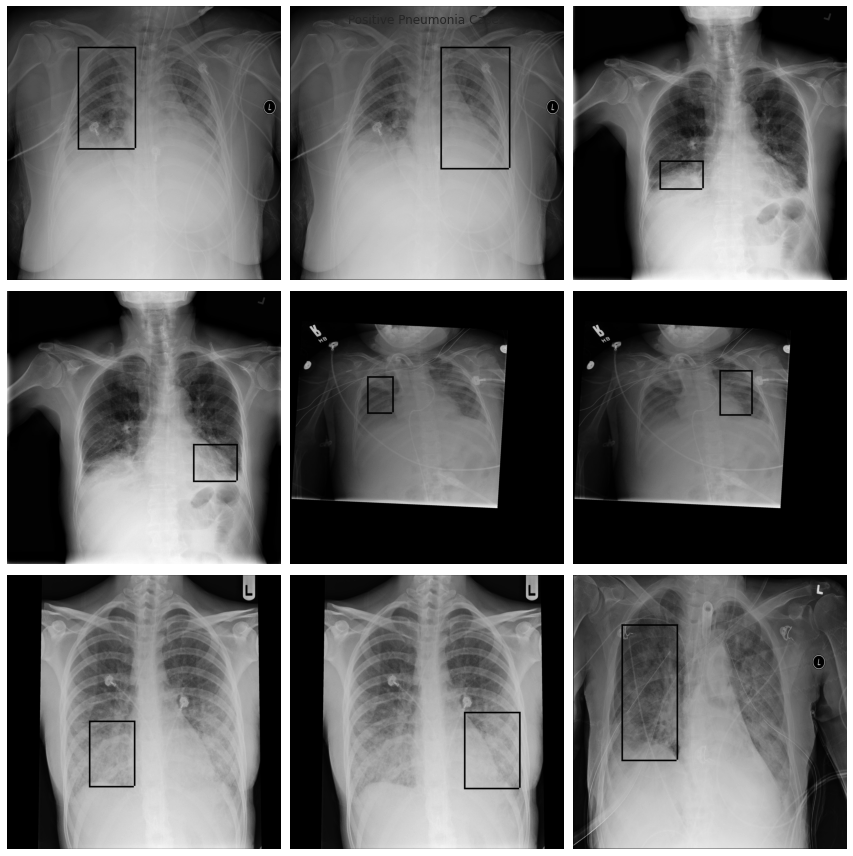

In [43]:
# Draw sample images in 3x3 matrix
plotIndex = 330
plt.figure(figsize=(12,12))
plt.suptitle('Positive Pneumonia Cases')

for index, row in pos_df[0:9].iterrows():
    plotIndex = plotIndex + 1
    plt.subplot(plotIndex)
    plt.axis('off')
    plt.imshow(processImage(row, 1), cmap=plt.cm.gist_gray) 
plt.tight_layout()

-- Visualize NEGATIVE pneumonia cases - 'No Lung Opacity / Not Normal' class category--

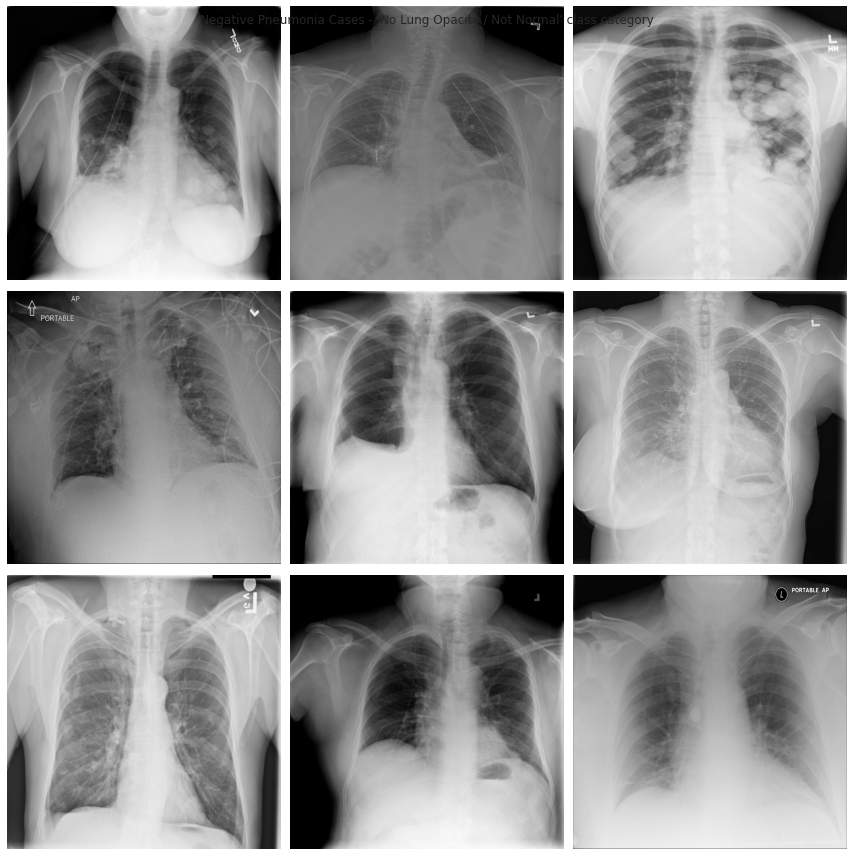

In [44]:
# Draw sample images in 3x3 matrix
plotIndex = 330
plt.figure(figsize=(12,12))
plt.suptitle('Negative Pneumonia Cases - \'No Lung Opacity / Not Normal\' class category')

for index, row in neg_not_normal_df[0:9].iterrows():
    plotIndex = plotIndex + 1
    plt.subplot(plotIndex)
    plt.axis('off')
    plt.imshow(processImage(row, 0), cmap=plt.cm.gist_gray)
plt.tight_layout()

-- Visualize NEGATIVE pneumonia cases - 'NORMAL' class category--

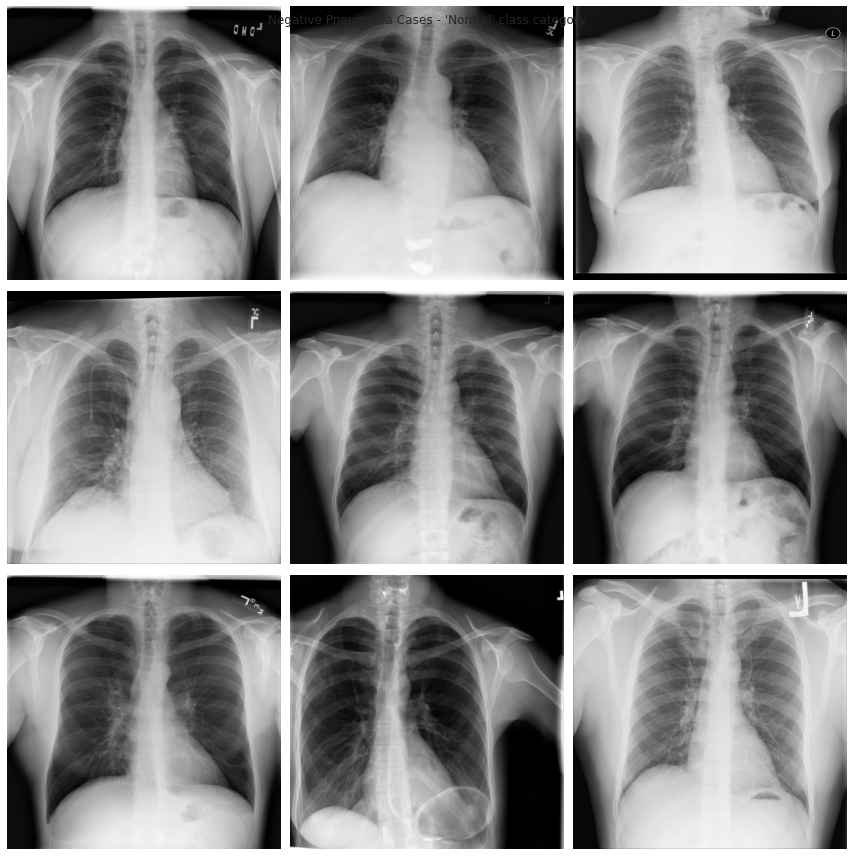

In [45]:
# Draw sample images in 3x3 matrix
plotIndex = 330
plt.figure(figsize=(12,12))
plt.suptitle('Negative Pneumonia Cases - \'Normal\' class category')

for index, row in neg_normal_df[0:9].iterrows():
    plotIndex = plotIndex + 1
    plt.subplot(plotIndex)
    plt.axis('off')
    plt.imshow(processImage(row, 0), cmap=plt.cm.gist_gray)
plt.tight_layout()

**Step 3 - Data Modeling**

* We need to load the image data in a format that can be used for model building and model evaluation
* This step will deal with loading the data into a form that is suitable for model building

In [46]:
train_data_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [47]:
# Replace all NaN's with 0's. This is required going forward for object detection.
# This will affect all records where 'Target = 0', 
# i.e., for Non-Pneunomic cases as bounding boxes are not applicable in those cases.
train_data_df.fillna(0, inplace=True)

In [48]:
pos_df = train_data_df[(train_data_df['Target'] == 1)]
neg_normal_df = train_data_df[(train_data_df['Target'] == 0) & (train_data_df['class'] == 'Normal')]
neg_not_normal_df = train_data_df[(train_data_df['Target'] == 0) & (train_data_df['class'] == 'No Lung Opacity / Not Normal')]

In [49]:
class_size = 6000
pos_sample = pos_df.sample(class_size)
neg_sample1 = neg_normal_df.sample(int(class_size/2))
neg_sample2 = neg_not_normal_df.sample(int(class_size/2))

train_sample_df = pd.concat([pos_sample, neg_sample1, neg_sample2], axis = 0)
train_sample_df['Target'].value_counts()

1    6000
0    6000
Name: Target, dtype: int64

In [50]:
train_sample_df.describe()

,x,y,width,height,Target
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,197.314333,182.842083,109.572000,164.643583,0.500000
std,244.797205,211.056734,117.356841,199.227540,0.500021
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,27.000000,22.500000,0.500000
75%,326.000000,364.000000,217.250000,296.000000,1.000000
max,835.000000,881.000000,528.000000,942.000000,1.000000


In [51]:
train_sample_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 25838 to 3948
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  12000 non-null  object 
 1   x          12000 non-null  float64
 2   y          12000 non-null  float64
 3   width      12000 non-null  float64
 4   height     12000 non-null  float64
 5   Target     12000 non-null  int64  
 6   class      12000 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 750.0+ KB


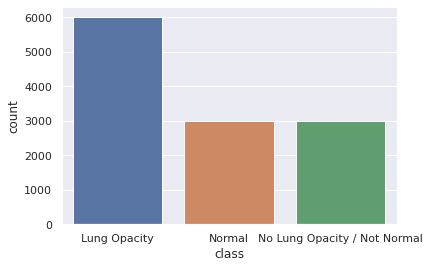

In [52]:
sns.countplot(train_sample_df['class']);

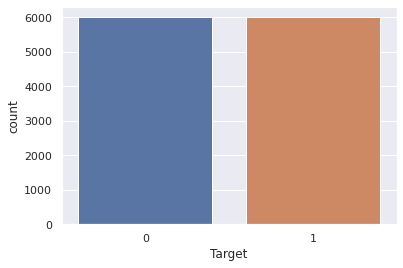

In [53]:
sns.countplot(train_sample_df['Target']);

In [54]:
train_sample_df.reset_index(inplace=True)

originalImageSize = 1024
imageSize = 224
imgList = []
targetCatList = []
no_of_images = train_sample_df.shape[0]
coordinates = np.zeros((no_of_images, 4))

for index, eachRow in train_sample_df.iterrows():
    
    #Extract patientId
    pId = eachRow['patientId']
    targetCat = eachRow['Target']

    #Make the dcm image page for patientId
    dicomFile = train_img_path + pId + '.dcm'
    
    #Get pixel_array of dcm image for display
    img = pydicom.read_file(dicomFile).pixel_array
    
    #Convert image to 3 channels
    img = np.stack([img] * 3, axis=2)
    
    #Resize image
    img = np.array(img).astype(np.uint8)
    img = cv2.resize(img, (imageSize, imageSize), interpolation = cv2.INTER_LINEAR)

    # coordinate
    x = eachRow['x'] / originalImageSize
    y = eachRow['y'] / originalImageSize
    height = eachRow['height'] / originalImageSize
    width = eachRow['width'] / originalImageSize
    
    #Add image to target list
    imgList.append(img)
    targetCatList.append(targetCat)

    #Record bounding box co-ordinates
    coordinates[index] = (np.array([x, y, width, height]))

#Convert list to array type (used for modeling)
imgArray = np.array(imgList)
targetCatArray = np.array(targetCatList)

In [55]:
imgArray.shape, targetCatArray.shape

((12000, 224, 224, 3), (12000,))

In [56]:
print(len(coordinates))
print(coordinates[0].shape)

12000
(4,)


In [57]:
from sklearn.preprocessing import LabelEncoder

# Create an object of LabelEncoder
le = LabelEncoder()

In [58]:
# Do fit_transform of target class of training data
targetCatEncoded = le.fit_transform(targetCatArray)

In [59]:
targetCatEncoded

array([1, 1, 1, ..., 0, 0, 0])

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
X_train, X_test, y_train, y_test, y_box_train, y_box_test = train_test_split(imgArray, targetCatEncoded, coordinates, test_size=0.2, random_state=1, stratify=targetCatEncoded)

print("Shape of X_train -> ", X_train.shape, ", Shape of y_train -> ", y_train.shape, ", Shape of y_box_train -> ", y_box_train.shape)
print("Shape of X_test -> ", X_test.shape, ", Shape of y_test -> ", y_test.shape, ", Shape of y_box_test -> ", y_box_test.shape)

Shape of X_train ->  (9600, 224, 224, 3) , Shape of y_train ->  (9600,) , Shape of y_box_train ->  (9600, 4)
Shape of X_test ->  (2400, 224, 224, 3) , Shape of y_test ->  (2400,) , Shape of y_box_test ->  (2400, 4)


In [62]:
imgArray = []
targetCatEncoded = []
coordinates = []

In [63]:
from tensorflow.keras.utils import to_categorical

In [64]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [65]:
y_train

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [66]:
y_test

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [67]:
X_train_copy = np.copy(X_train)
X_test_copy = np.copy(X_test)

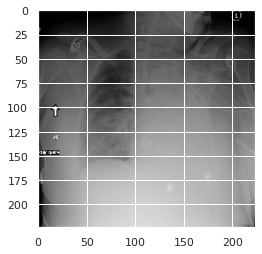

In [70]:
plt.imshow(X_test[0].astype("uint8"))

In [71]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [72]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [73]:
X_train.shape, X_test.shape

((9600, 224, 224, 3), (2400, 224, 224, 3))

In [74]:
from keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet = Model(inputs=[base_model.input], outputs=[base_model.layers[-1].output])

for layer in resnet.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 1s 0us/step


In [75]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten

classification_output = GlobalAveragePooling2D()(resnet.output)
classification_output = Dense(units=512, activation='relu')(classification_output)
classification_output = Dense(units=512, activation='relu')(classification_output)
classification_output = Dense(units=4, activation='relu')(classification_output)
classification_output = Dense(units=2, activation='softmax', name="CLASSIFICATION_OUT")(classification_output)

localization_output = Flatten()(resnet.output)
localization_output = Dense(units=128, activation='relu')(localization_output)
localization_output = Dense(units=64, activation='relu')(localization_output)
localization_output = Dense(units=32, activation='relu')(localization_output)
localization_output = Dense(units=4, activation='linear', name="BBOX_OUT")(localization_output)

model = Model(inputs=[resnet.input], outputs=[classification_output, localization_output])

In [76]:
from tensorflow.keras import optimizers

#Define losses
losses = {
    "BBOX_OUT": "mean_squared_error",
    "CLASSIFICATION_OUT": "categorical_crossentropy"
}

#Define loss weights
loss_weights = {
    "BBOX_OUT": 1.0,
    "CLASSIFICATION_OUT": 1.0
}

#Define metrics
metrics = {
    'BBOX_OUT': 'mse',
    'CLASSIFICATION_OUT':  'accuracy'
}

# Initialize Optimizer
opt = optimizers.Adam(learning_rate=0.001)

In [77]:
# Compile the model
model.compile(optimizer = opt, loss = losses, loss_weights = loss_weights, metrics = metrics)

In [78]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [84]:
# Train the Model
history = model.fit(x = X_train, 
                    y = {"BBOX_OUT": y_box_train, "CLASSIFICATION_OUT": y_train}, 
                    validation_data = 
                    (
                        X_test, 
                        {"BBOX_OUT": y_box_test, "CLASSIFICATION_OUT": y_test}
                    ), 
                    epochs = 50, verbose = True)

Epoch 1/50
300/300 [==============================] - 53s 126ms/step - loss: 9.9317 - CLASSIFICATION_OUT_loss: 0.5864 - BBOX_OUT_loss: 9.3452 - CLASSIFICATION_OUT_accuracy: 0.7586 - BBOX_OUT_mse: 9.3452 - val_loss: 1.3733 - val_CLASSIFICATION_OUT_loss: 0.5410 - val_BBOX_OUT_loss: 0.8324 - val_CLASSIFICATION_OUT_accuracy: 0.7771 - val_BBOX_OUT_mse: 0.8324
Epoch 2/50
300/300 [==============================] - 35s 116ms/step - loss: 1.5395 - CLASSIFICATION_OUT_loss: 0.5210 - BBOX_OUT_loss: 1.0185 - CLASSIFICATION_OUT_accuracy: 0.7837 - BBOX_OUT_mse: 1.0185 - val_loss: 0.9896 - val_CLASSIFICATION_OUT_loss: 0.5254 - val_BBOX_OUT_loss: 0.4642 - val_CLASSIFICATION_OUT_accuracy: 0.7654 - val_BBOX_OUT_mse: 0.4642
Epoch 3/50
300/300 [==============================] - 35s 117ms/step - loss: 1.5073 - CLASSIFICATION_OUT_loss: 0.4841 - BBOX_OUT_loss: 1.0232 - CLASSIFICATION_OUT_accuracy: 0.7975 - BBOX_OUT_mse: 1.0232 - val_loss: 1.0343 - val_CLASSIFICATION_OUT_loss: 0.4895 - val_BBOX_OUT_loss: 0.544

In [85]:
model.save("/content/gdrive/MyDrive/Learning_Shared/Capstone_RESNET50")

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Learning_Shared/Capstone_RESNET50/assets


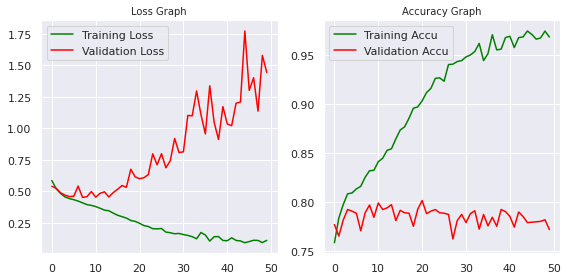

In [86]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax[0].set_title("Loss Graph", fontsize=10)
ax[0].plot(history.history["CLASSIFICATION_OUT_loss"], color='green')
ax[0].plot(history.history["val_CLASSIFICATION_OUT_loss"], color='red')
ax[0].legend(["Training Loss", "Validation Loss"], loc='best')

ax[1].set_title("Accuracy Graph", fontsize=10)
ax[1].plot(history.history["CLASSIFICATION_OUT_accuracy"], color='green')
ax[1].plot(history.history["val_CLASSIFICATION_OUT_accuracy"], color='red')
ax[1].legend(["Training Accu", "Validation Accu"], loc='best')

plt.tight_layout()
plt.show()

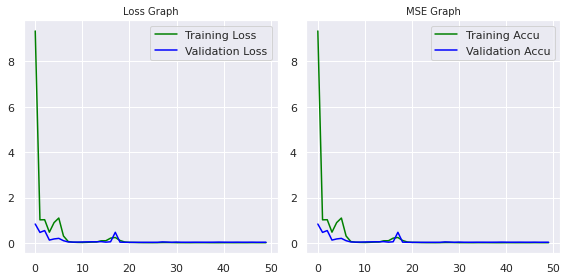

In [87]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

plt.title('Bounding box Regression Plots')

ax[0].set_title("Loss Graph", fontsize=10)
ax[0].plot(history.history["BBOX_OUT_loss"], color='green')
ax[0].plot(history.history["val_BBOX_OUT_loss"], color='blue')
ax[0].legend(["Training Loss", "Validation Loss"], loc='best')

ax[1].set_title("MSE Graph", fontsize=10)
ax[1].plot(history.history["BBOX_OUT_mse"], color='green')
ax[1].plot(history.history["val_BBOX_OUT_mse"], color='blue')
ax[1].legend(["Training Accu", "Validation Accu"], loc='best')

plt.tight_layout()
plt.show()

**Lets browse through test images randomly and see our predictions**

In [116]:
def getTestImage(patientId):
    #Make the dcm image page for patientId
    dicomFile = test_img_path + patientId + '.dcm'
    
    #Get pixel_array of dcm image for display
    img = pydicom.read_file(dicomFile).pixel_array

    #Convert image to 3 channels, Resize and load training image
    img = np.stack([img] * 3, axis=2)
    img = cv2.resize(img, (imageSize, imageSize), interpolation = cv2.INTER_LINEAR)

    return img

In [117]:
predictions_df = sample_submission_df.copy()
originalImageSize = 1024
imageSize = 224
sample_submission_size = predictions_df.shape[0]

for i in range(30):
    pId = predictions_df.iloc[i]['patientId']

    img = getTestImage(pId)

    img = preprocess_input(img)

    image_array = np.array([img])
    pred = model.predict(image_array)

    if np.argmax(pred[0][0]) == 0:
      predictions_df.iloc[i]['PredictionString'] = str(round(pred[0][0][0],3)) + " 0 0 0 0"
    else:
      confidence = round(pred[0][0][1], 3)
      x = round((pred[1][0][0] * originalImageSize), 2)
      y = round((pred[1][0][1] * originalImageSize), 2)
      width = round((pred[1][0][2] * originalImageSize), 2)
      height = round((pred[1][0][3] * originalImageSize), 2)
      predictions_df.iloc[i]['PredictionString'] = str(confidence) + " " + str(x) + " " + str(y) + " " + str(width) + " " + str(height)

In [118]:
predictions_df.head(20)

,patientId,PredictionString
0,0000a175-0e68-4ca4-b1af-167204a7e0bc,0.963 0 0 0 0
1,0005d3cc-3c3f-40b9-93c3-46231c3eb813,0.963 0 0 0 0
2,000686d7-f4fc-448d-97a0-44fa9c5d3aa6,0.963 0 0 0 0
3,000e3a7d-c0ca-4349-bb26-5af2d8993c3d,0.963 0 0 0 0
4,00100a24-854d-423d-a092-edcf6179e061,1.0 696.16 572.4 260.25 214.21
5,0015597f-2d69-4bc7-b642-5b5e01534676,0.999 9.92 14.83 8.46 3.63
6,001b0c51-c7b3-45c1-9c17-fa7594cab96e,0.93 0 0 0 0
7,0022bb50-bf6c-4185-843e-403a9cc1ea80,0.977 0.6 2.36 -4.81 -11.47
8,00271e8e-aea8-4f0a-8a34-3025831f1079,0.963 0 0 0 0
9,0028450f-5b8e-4695-9416-8340b6f686b0,0.706 0 0 0 0
